In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP & Text Preprocessing
import re
from bs4 import BeautifulSoup
import spacy
from collections import Counter

# Scikit-learn: Data Handling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Scikit-learn: Text Processing
from sklearn.feature_extraction.text import TfidfVectorizer

# Scikit-learn: Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Scikit-learn: Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Utilities
import warnings

warnings.filterwarnings('ignore')

In [2]:
true_df = pd.read_csv("../data/Fake.csv")
fake_df = pd.read_csv("../data/True.csv")

In [3]:
fake_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
true_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
fake_df['label'] = 'fake'   # Fake
true_df['label'] = 'real'   # Real
df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

In [6]:
df.tail()

,title,text,subject,date,label
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",real
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",real
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",real
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",real
44897,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",real


In [7]:
df['combined_text'] = df['title'] + ' ' + df['text']

In [8]:
df['label'].unique()

array(['fake', 'real'], dtype=object)

In [9]:
df['subject'].unique()

array(['politicsNews', 'worldnews', 'News', 'politics', 'Government News',
       'left-news', 'US_News', 'Middle-east'], dtype=object)

In [10]:
# Clean up unused columns
df = df.drop(columns=['date', 'title', 'text'])

In [11]:
df.head()

,subject,label,combined_text
0,politicsNews,fake,"As U.S. budget fight looms, Republicans flip t..."
1,politicsNews,fake,U.S. military to accept transgender recruits o...
2,politicsNews,fake,Senior U.S. Republican senator: 'Let Mr. Muell...
3,politicsNews,fake,FBI Russia probe helped by Australian diplomat...
4,politicsNews,fake,Trump wants Postal Service to charge 'much mor...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   subject        44898 non-null  object
 1   label          44898 non-null  object
 2   combined_text  44898 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [13]:
df.duplicated().sum()

np.int64(213)

In [14]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [15]:
# Load spaCy English model
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, 'lxml')
    text = soup.get_text(separator=' ')

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Process with spaCy
    doc = nlp(text.lower())

    # Remove stopwords + non-alphabetic + lemmatize
    tokens = [
        token.lemma_
        for token in doc
        if token.is_alpha and not token.is_stop
    ]

    # Join tokens back to string
    return ' '.join(tokens)

df['cleaned_text'] = df['combined_text'].apply(preprocess_text)

In [16]:
df.head()

,subject,label,combined_text,cleaned_text
0,politicsNews,fake,"As U.S. budget fight looms, Republicans flip t...",budget fight loom republicans flip fiscal scri...
1,politicsNews,fake,U.S. military to accept transgender recruits o...,military accept transgender recruit monday pen...
2,politicsNews,fake,Senior U.S. Republican senator: 'Let Mr. Muell...,senior republican senator let mr mueller job w...
3,politicsNews,fake,FBI Russia probe helped by Australian diplomat...,fbi russia probe help australian diplomat tip ...
4,politicsNews,fake,Trump wants Postal Service to charge 'much mor...,trump want postal service charge amazon shipme...


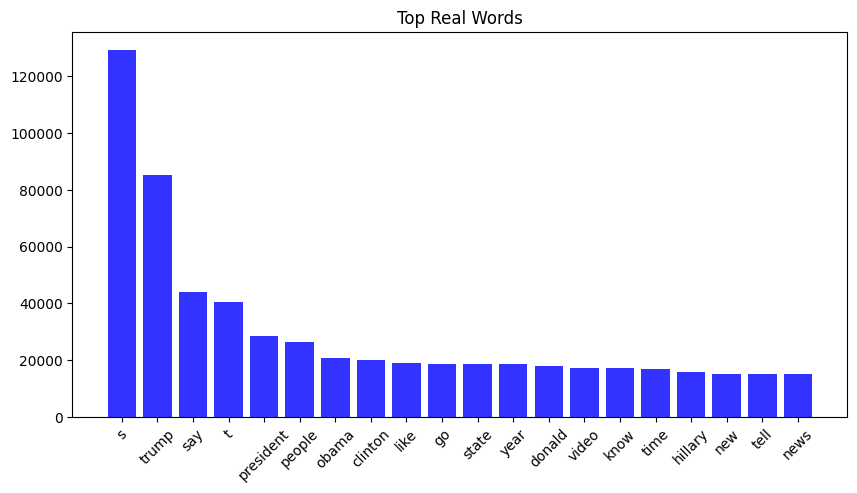

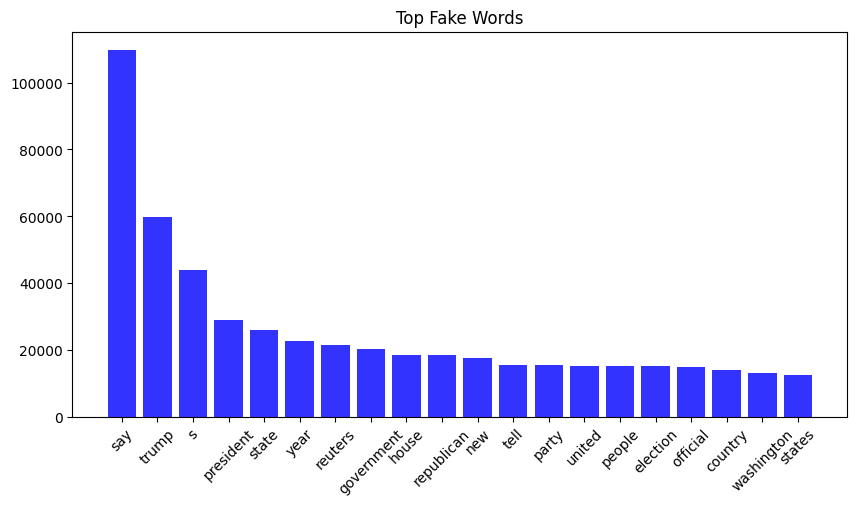

In [17]:
# Visualize the most frequent words per category using bar plots
true_words = ' '.join(df[df['label']=='real']['cleaned_text'])
fake_words = ' '.join(df[df['label']=='fake']['cleaned_text'])

def most_common_words(text, title, n):
    if not text:
        print(f'No words found for {title}')
        return

    words = text.split()  # Split the text into words
    counter = Counter(words)
    common = counter.most_common(n) # Get the top n most common words

    if not common:
        print(f'No words found for {title}')
        return

    words, counts = zip(*common)
    plt.figure(figsize=(10,5))
    plt.bar(words, counts, color='#33f')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

most_common_words(true_words, 'Top Real Words', 20)
most_common_words(fake_words, 'Top Fake Words', 20)

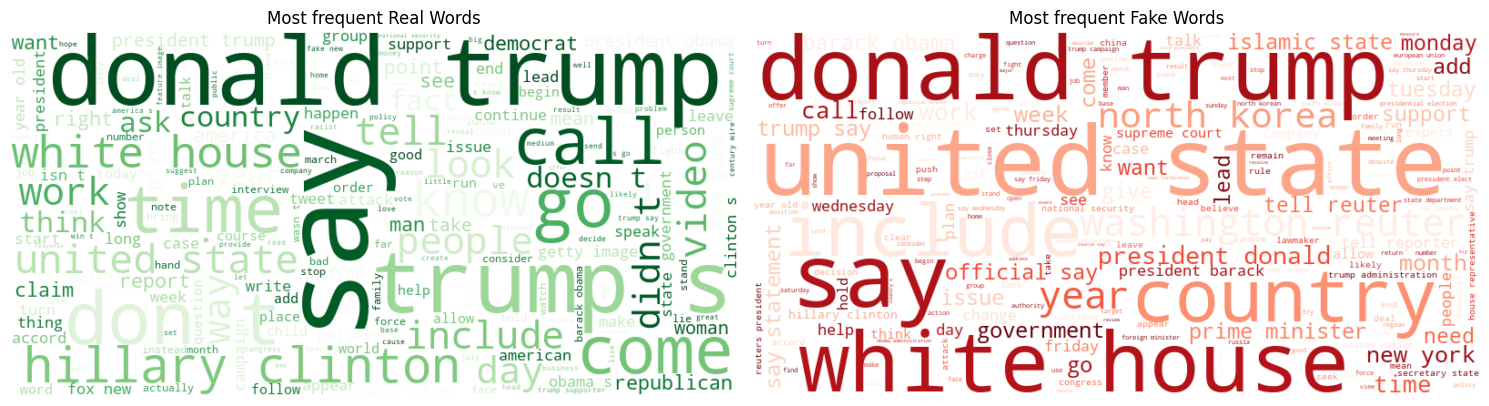

In [18]:
# Visualize the most frequent words per category using word clouds
true_WordCloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(true_words)
fake_WordCloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(fake_words)

plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.imshow(true_WordCloud, interpolation='bilinear')
plt.title('Most frequent Real Words')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(fake_WordCloud, interpolation='bilinear')
plt.title('Most frequent Fake Words')
plt.axis('off')

plt.tight_layout()
plt.show()

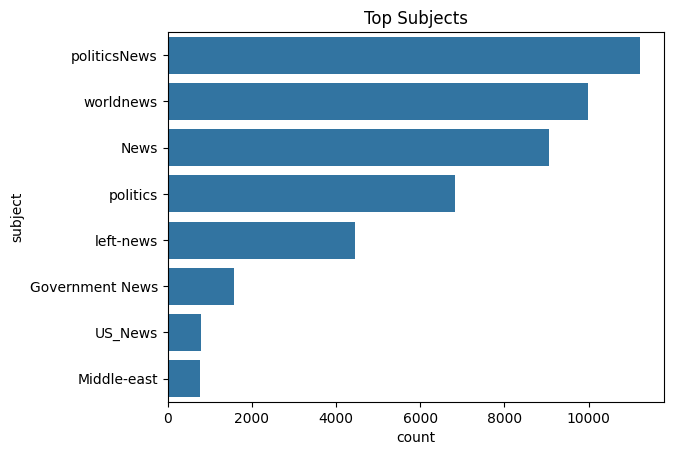

In [19]:
if 'subject' in df.columns:
    sns.countplot(data=df, y='subject', order=df['subject'].value_counts().index)
    plt.title('Top Subjects')
    plt.show()

In [20]:
data = df.copy()
data.shape

(44685, 4)

In [21]:
# Train-Test Split
X = data['combined_text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

# Build Pipelines with Multiple Models
models = {
    'Logistic Regression': LogisticRegression(solver='saga', max_iter=1000, random_state=23),
    'SVM': LinearSVC(random_state=23)
}

result = {}

for name, regressor in models.items():
    pipeline = Pipeline([
        ('preprocessor', TfidfVectorizer(ngram_range=(1,2), max_df=0.8, min_df=5)),
        ('regressor', regressor)
    ])

    # Train and evaluate the model
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    result[name] = accuracy

    print(f'Model: {name}')
    print(f'Accuracy: {accuracy}')
    print(f'Classification Report\n {classification_report(y_test, y_pred)}\n')

Model: Logistic Regression
Accuracy: 0.9876916191115587
Classification Report
               precision    recall  f1-score   support

        fake       0.99      0.99      0.99      4242
        real       0.99      0.99      0.99      4695

    accuracy                           0.99      8937
   macro avg       0.99      0.99      0.99      8937
weighted avg       0.99      0.99      0.99      8937


Model: SVM
Accuracy: 0.9961955913617545
Classification Report
               precision    recall  f1-score   support

        fake       1.00      1.00      1.00      4242
        real       1.00      1.00      1.00      4695

    accuracy                           1.00      8937
   macro avg       1.00      1.00      1.00      8937
weighted avg       1.00      1.00      1.00      8937




In [22]:
# Find the best model
best_model = max(result, key=result.get)
best_accuracy = result[best_model]
print(f'The best model is {best_model}, with an accuracy of {best_accuracy}')

The best model is SVM, with an accuracy of 0.9961955913617545


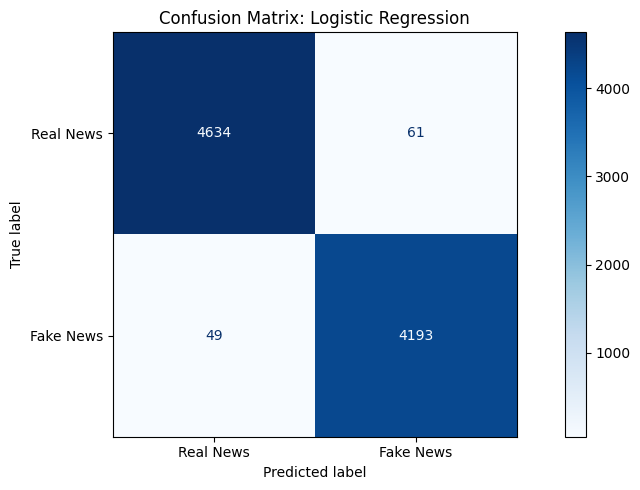

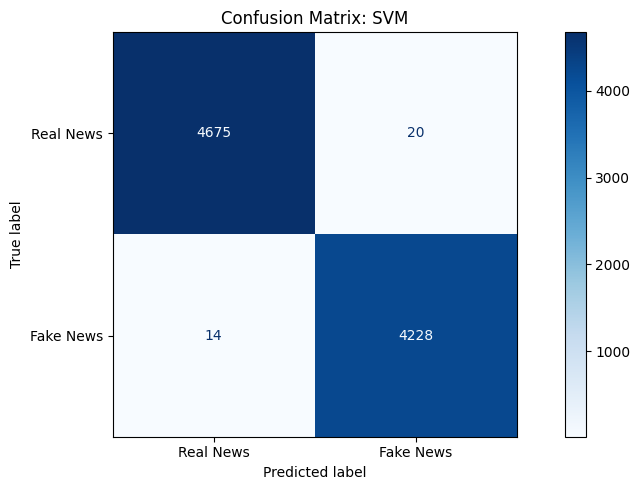

In [23]:
# Confusion Matrix for the best modelpipeline = Pipeline([
for name, regressor in models.items():
    pipeline = Pipeline([
        ('preprocessor', TfidfVectorizer(ngram_range=(1,2), max_df=0.8, min_df=5)),
        ('regressor', regressor)
    ])

# Train and evaluate the model
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    fig, ax = plt.subplots(figsize=(10,5))
    cm = confusion_matrix(y_test, y_pred, labels=['real', 'fake'])
    ConfusionMatrixDisplay(cm, display_labels=['Real News', 'Fake News']).plot(cmap='Blues', ax=ax)
    plt.title(f'Confusion Matrix: {name}')
    plt.tight_layout()
    plt.show()

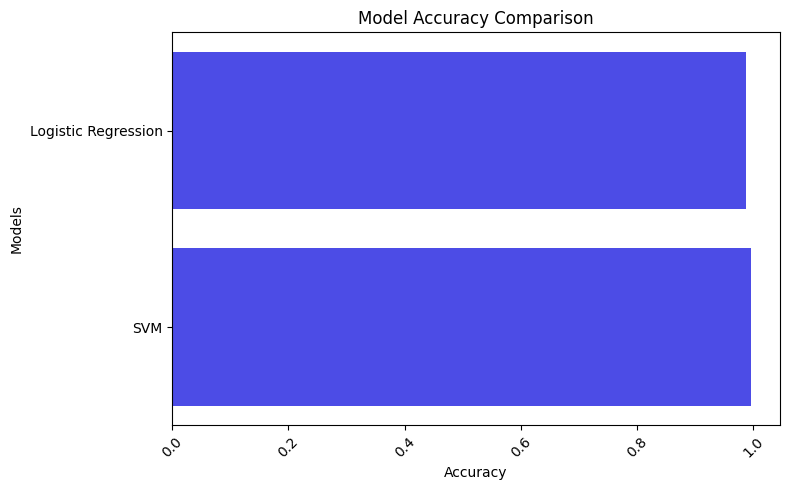

In [24]:
# Compare Model Accuracies
plt.figure(figsize=(8,5))
sns.barplot(x=result.values(), y=result.keys(), color='#33f')
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.xticks(rotation=45)
plt.title('Model Accuracy Comparison')
plt.tight_layout()
plt.show()

In [ ]:
# Predict on New Reviews
sample_reviews=[
    'Authorities in Nigeria are increasing efforts to tackle investment scams, especially those involving crypto platforms.',
    'NASA secretly admitted that the Moon landing was faked and astronauts never left Earth.',
    'The government successfully passed a new education reform bill today, aiming to improve access to schools and increase funding for teachers. Lawmakers and citizens praised the initiative as a major step forward for the country’s future.'
]
best_model = Pipeline([
    ('preprocessor', TfidfVectorizer()),
    ('regressor', LinearSVC(random_state=23))
])
best_model.fit(X_train, y_train)
preds = best_model.predict(sample_reviews)
for i, (j, k) in enumerate(zip(sample_reviews, preds)):
    print(f'\n{i}. Review: {j}\nPredicted Score: {k}')


0. Review: Authorities in Nigeria are increasing efforts to tackle investment scams, especially those involving crypto platforms.
Predicted Score: fake

1. Review: NASA secretly admitted that the Moon landing was faked and astronauts never left Earth.
Predicted Score: real

2. Review: The government successfully passed a new education reform bill today, aiming to improve access to schools and increase funding for teachers. Lawmakers and citizens praised the initiative as a major step forward for the country’s future.
Predicted Score: fake

3. Review: Tinubu is gay
Predicted Score: real


In [26]:
joblib.dump(pipeline, 'model.joblib')
print('✅ Pipeline trained and saved as model.joblib')

✅ Pipeline trained and saved as model.joblib
